In [38]:
#Loading in the dataset
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader


amazon = pd.read_csv('AMAZON_daily.csv')
amazon=amazon[['Date', 'Close']]

apple = pd.read_csv('APPLE_daily.csv')
apple=apple[['Date', 'Close']]

google = pd.read_csv('GOOGLE_daily.csv')
google=google[['Date', 'Close']]

meta = pd.read_csv('META_daily.csv')
meta=meta[['Date', 'Close']]

netflix = pd.read_csv('NETFLIX_daily.csv')
netflix=netflix[['Date', 'Close']]

#my GPU is AMD Radeon (too complicated to use on my computer)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [39]:
##Predicting with weeks instead, using the average of 5 days as the week (no data collected on weekends)

def find_avg_weeks(X, days):
    length = len(X)//days
    X['Date'] = pd.to_datetime(X['Date'])
    new_X = []
    for i in range(length):
        new_X.append(X.iloc[days*i:days*i+days,:].mean())
    return pd.DataFrame(new_X).reset_index(drop=True)

amazon_week = find_avg_weeks(amazon, 5)
apple_week =find_avg_weeks(apple,5)
google_week = find_avg_weeks(apple,5)
meta_week = find_avg_weeks(meta, 5)
netflix_week = find_avg_weeks(netflix, 5)

In [40]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{n_steps+1-i})'] = df['Close'].shift(n_steps+1-i)

    df.dropna(inplace=True)

    return df

lookback=7
amazon_week_shift = prepare_dataframe_for_lstm(amazon_week, lookback)
apple_week_shift = prepare_dataframe_for_lstm(apple_week, lookback)
google_week_shift = prepare_dataframe_for_lstm(google_week, lookback)
meta_week_shift = prepare_dataframe_for_lstm(meta_week, lookback)
netflix_week_shift = prepare_dataframe_for_lstm(netflix_week, lookback)

In [41]:
##Adding one hot encoding (again)
amazon_week_np = amazon_week_shift.to_numpy() # won't show date column since data is index
amazon_week_np= np.hstack((amazon_week_np, np.ones((len(amazon_week_np),1))))
amazon_week_np = np.hstack((amazon_week_np, np.zeros((len(amazon_week_np), 4))))

apple_week_np = apple_week_shift.to_numpy()
apple_week_np = np.hstack((apple_week_np, np.zeros((len(apple_week_np), 1))))
apple_week_np = np.hstack((apple_week_np, np.ones((len(apple_week_np), 1))))
apple_week_np = np.hstack((apple_week_np, np.zeros((len(apple_week_np), 3))))

google_week_np = google_week_shift.to_numpy()
google_week_np = np.hstack((google_week_np, np.zeros((len(google_week_np), 2))))
google_week_np = np.hstack((google_week_np, np.ones((len(google_week_np), 1))))
google_week_np = np.hstack((google_week_np, np.zeros((len(google_week_np), 2))))

meta_week_np = meta_week_shift.to_numpy()
meta_week_np = np.hstack((meta_week_np, np.zeros((len(meta_week_np), 3))))
meta_week_np = np.hstack((meta_week_np, np.ones((len(meta_week_np), 1))))
meta_week_np = np.hstack((meta_week_np, np.zeros((len(meta_week_np), 1))))

netflix_week_np = netflix_week_shift.to_numpy()
netflix_week_np = np.hstack((netflix_week_np, np.zeros((len(netflix_week_np),4))))
netflix_week_np = np.hstack((netflix_week_np, np.ones((len(netflix_week_np), 1))))

shifted_week_np = np.vstack((amazon_week_np, apple_week_np, google_week_np, meta_week_np, netflix_week_np))
shifted_week_np[:,0]

array([Timestamp('1997-07-09 00:00:00'), Timestamp('1997-07-16 00:00:00'),
       Timestamp('1997-07-23 00:00:00'), ...,
       Timestamp('2025-04-16 14:24:00'), Timestamp('2025-04-24 09:36:00'),
       Timestamp('2025-05-01 09:36:00')], dtype=object)

In [42]:
#only after 2013
first_week = np.datetime64('2013-01-01 00:00:00')
ind_week = shifted_week_np[:,0] >= first_week
shifted_week_np = shifted_week_np[ind_week]

#split the dataset
cutoff_date_week = np.quantile(shifted_week_np[:,0],0.8)
test_ind_week = shifted_week_np[:,0] >= cutoff_date_week
train_ind_week = shifted_week_np[:,0] < cutoff_date_week

shifted_week_np = np.delete(shifted_week_np, 0, 1)

#Normalize
from sklearn.preprocessing import MinMaxScaler

scaler_weeky = MinMaxScaler(feature_range=(-1,1)) #video said feature_range=(-1,1)
#this does std = (x-min)(max-min), x_new = std*(min-max)+min

shifted_week_np[:,0] = (scaler_weeky.fit_transform(shifted_week_np[:,0].reshape(-1,1))).reshape(-1)

scaler_weekx = MinMaxScaler(feature_range=(-1,1))
shifted_week_np[:,1:lookback+1] = scaler_weekx.fit_transform(shifted_week_np[:,1:lookback+1])

In [43]:
# Define X,y, and split into training and testing
X_week =shifted_week_np[:,1:]
y_week=shifted_week_np[:,0]

#Spliting into train and test
X_week_train = X_week[train_ind_week]
X_week_test = X_week[test_ind_week]
y_week_train = y_week[train_ind_week]
y_week_test = y_week[test_ind_week]


#pytorch wants another dimension so:
X_week_train_np = (X_week_train.reshape((-1, lookback+5, 1))).astype(float)
X_week_test_np = (X_week_test.reshape((-1,lookback+5, 1))).astype(float)

y_week_train_np = (y_week_train.reshape((-1,1))).astype(float)
y_week_test_np = (y_week_test.reshape((-1,1))).astype(float)

In [44]:
#Wrap in tensors for pytorch
X_week_train = torch.tensor(X_week_train_np).float()
X_week_test = torch.tensor(X_week_test_np).float()
y_week_train = torch.tensor(y_week_train_np).float()
y_week_test = torch.tensor(y_week_test_np).float()

#Turn into dataset object (need custom class) - Got this custom class from tutorial video
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X =X
        self.y =y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i): #square brackets indexing
        return self.X[i], self.y[i]
#Wrap in dataset defined above
train_week_dataset = TimeSeriesDataset(X_week_train, y_week_train)
test_week_dataset = TimeSeriesDataset(X_week_test, y_week_test)

#Put into dataloader
from torch.utils.data import DataLoader

batch_size=16
train_week_loader = DataLoader(train_week_dataset, batch_size=batch_size, shuffle=True)
test_week_loader = DataLoader(test_week_dataset, batch_size = batch_size, shuffle=False)

In [45]:
##Building the model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, lookback, num_lin_lay, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.lookback =lookback
        self.num_stacked_layers = num_stacked_layers
        self.num_lin_lay = num_lin_lay

        #need this for grid search
        effective_dropout = dropout if num_stacked_layers > 1 else 0.0 #in both cases, actually not using dropout since only have 1 stacked layer.

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, dropout=effective_dropout,batch_first=True)
        if num_lin_lay == 2:#num_lin_lay must be either 1 and 2
            self.fc2 = nn.Linear(hidden_size+5, hidden_size+5)        
        self.fc = nn.Linear(hidden_size+5, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #h0 is gate vectors, must initialize with particular shape
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x[:,:lookback],(h0, c0))
        temporary = torch.cat((out[:,-1,:], x[:, lookback:,0]), dim=1)
        
        if self.num_lin_lay ==2:
            temp2 = self.fc2(temporary)
            out = self.fc(temp2)
        else:
            out = self.fc(temporary)
        return out

In [46]:
##Training function
def train_one_epoch(m,epoch, optimizer, loss_function, trainload, device):
    m.train(True) #set to training mode
    print(f'Epoch: {epoch+1}')
    running_loss=0.0

    for batch_index, batch in enumerate(trainload):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #gets a batch and puts on device we use

        output = m(x_batch) #gets output of model
        loss = loss_function(output, y_batch) #compares outputs to ground truth
        running_loss += loss.item()
        optimizer.zero_grad() #zero out gradients
        loss.backward() #backward pass to calculate gradients
        optimizer.step() #slight step in direction of gradient

        if batch_index %100 ==99: #prints every 100 batches
            avg_loss = running_loss/100
            print('Batch {0}, Average Loss: {1:.10f}'.format(batch_index+1, avg_loss))

            running_loss=0.0 #reset back to 0
    print() #for a blank line space

In [47]:
##Validation function
def validate_one_epoch(m, loss_function, testload, device):
    m.train(False) #will not update weights
    running_loss=0.0

    for batch_index, batch in enumerate(testload):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): #set to not update weights or change model
            output = m(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss = running_loss/len(testload)

    print('Validation loss:{0:.10f}'.format(avg_loss))
    print('**********************************************************') #looks good
    print() 
    return avg_loss

In [48]:
final_week=LSTM(1,32,1,7,1,0.5)
#Training
##Hyperparameters:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(final_week.parameters(), lr=learning_rate, weight_decay=0.001)

for epoch in range(num_epochs):
    train_one_epoch(final_week,epoch, optimizer, loss_function, train_week_loader,device) 
    validate_one_epoch(final_week, loss_function, test_week_loader,device)

Epoch: 1
Batch 100, Average Loss: 0.2348113708

Validation loss:0.0485174172
**********************************************************

Epoch: 2
Batch 100, Average Loss: 0.0079196458

Validation loss:0.0220126826
**********************************************************

Epoch: 3
Batch 100, Average Loss: 0.0028313299

Validation loss:0.0154024363
**********************************************************

Epoch: 4
Batch 100, Average Loss: 0.0014145374

Validation loss:0.0129370717
**********************************************************

Epoch: 5
Batch 100, Average Loss: 0.0008972083

Validation loss:0.0115129938
**********************************************************

Epoch: 6
Batch 100, Average Loss: 0.0008402260

Validation loss:0.0105956886
**********************************************************

Epoch: 7
Batch 100, Average Loss: 0.0007655996

Validation loss:0.0097312164
**********************************************************

Epoch: 8
Batch 100, Average Loss: 0.00069

In [49]:
##graphing stuff
ind_test_week_am = ((X_week_test[:,7,0]==1).nonzero()).reshape(-1)
x_test_week_am = X_week_test[ind_test_week_am]

ind_test_week_ap = ((X_week_test[:,8,0]==1).nonzero()).reshape(-1)
x_test_week_ap = X_week_test[ind_test_week_ap]

ind_test_week_go = ((X_week_test[:,9,0]==1).nonzero()).reshape(-1)
x_test_week_go = X_week_test[ind_test_week_go]

ind_test_week_me = ((X_week_test[:,10,0]==1).nonzero()).reshape(-1)
x_test_week_me = X_week_test[ind_test_week_me]

ind_test_week_ne = ((X_week_test[:,11,0]==1).nonzero()).reshape(-1)
x_test_week_ne = X_week_test[ind_test_week_ne]


with torch.no_grad():
    predicted_test_week_am = final_week(x_test_week_am.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_test_week_ap = final_week(x_test_week_ap.to(device)).to('cpu').numpy()
    predicted_test_week_go = final_week(x_test_week_go.to(device)).to('cpu').numpy()
    predicted_test_week_me = final_week(x_test_week_me.to(device)).to('cpu').numpy()
    predicted_test_week_ne = final_week(x_test_week_ne.to(device)).to('cpu').numpy()
    y_pred = final_week(X_week_test.to(device)).to('cpu').numpy()


from sklearn.metrics import mean_squared_error
print('MSE:{}'.format(mean_squared_error(y_pred,y_week_test)))

##Must inverse transform because normalized data
test_pred_week_am = scaler_weeky.inverse_transform(predicted_test_week_am)
y_test_week_am = scaler_weeky.inverse_transform(y_week_test[ind_test_week_am]) # Do the same for ground truth
#apple
test_pred_week_ap = scaler_weeky.inverse_transform(predicted_test_week_ap)
y_test_week_ap = scaler_weeky.inverse_transform(y_week_test[ind_test_week_ap])
#Google
test_pred_week_go = scaler_weeky.inverse_transform(predicted_test_week_go)
y_test_week_go = scaler_weeky.inverse_transform(y_week_test[ind_test_week_go])
#meta
test_pred_week_me = scaler_weeky.inverse_transform(predicted_test_week_me)
y_test_week_me = scaler_weeky.inverse_transform(y_week_test[ind_test_week_me])
#netflix
test_pred_week_ne = scaler_weeky.inverse_transform(predicted_test_week_ne)
y_test_week_ne = scaler_weeky.inverse_transform(y_week_test[ind_test_week_ne])

MSE:0.0036837770603597164


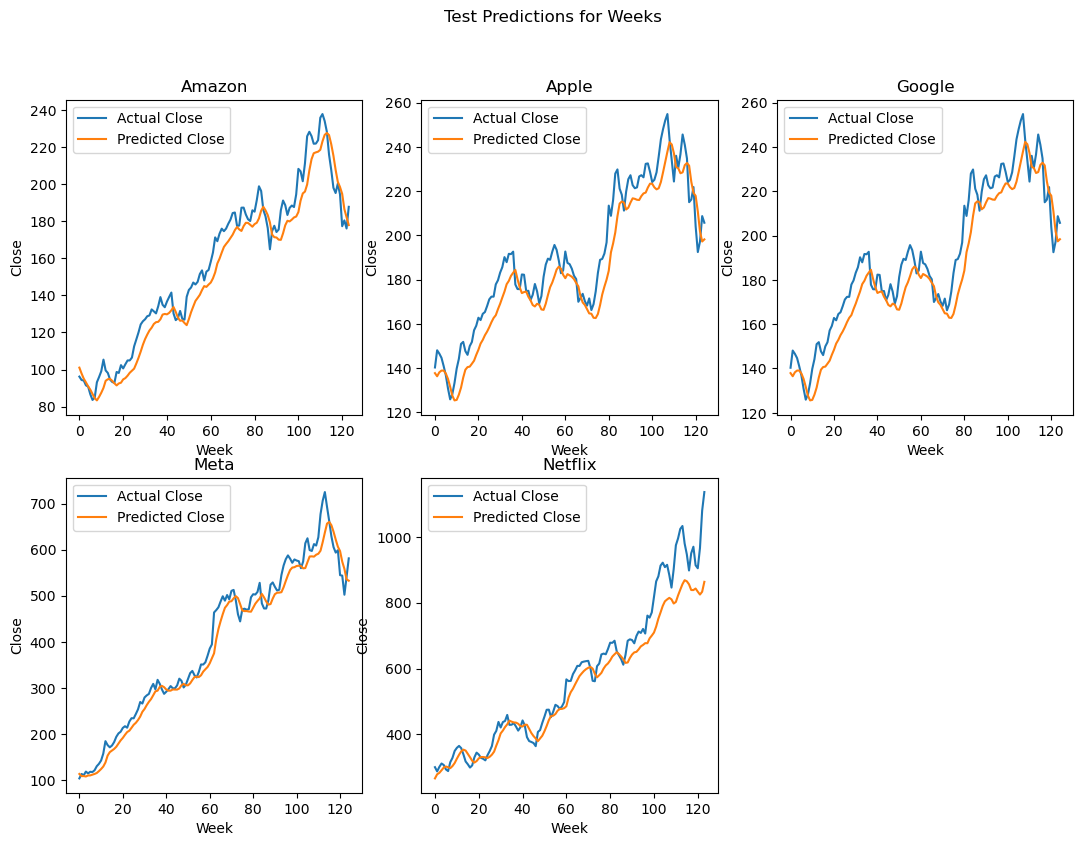

In [50]:
#Graphing Testing
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_test_week_am, label='Actual Close')
plt.plot(test_pred_week_am, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_test_week_ap, label='Actual Close')
plt.plot(test_pred_week_ap, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_test_week_go, label='Actual Close')
plt.plot(test_pred_week_go, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_test_week_me, label='Actual Close')
plt.plot(test_pred_week_me, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_test_week_ne, label='Actual Close')
plt.plot(test_pred_week_ne, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Test Predictions for Weeks')
plt.show()

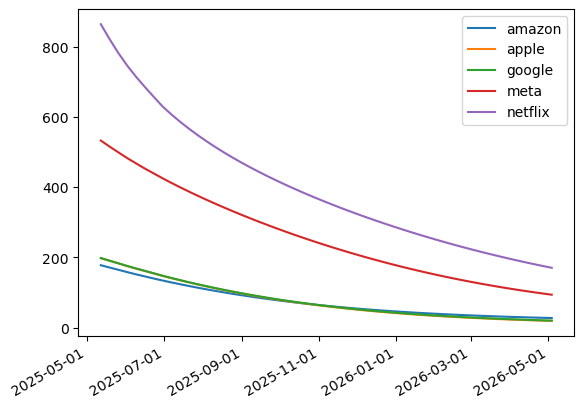

In [51]:
#Predict on future data:
def predict_future(model, X, num_iter):
    y_preds=[]
    with torch.no_grad():
        for _ in range(num_iter):
            y_pred = model(X.to(device))
            y_preds.append(y_pred.to('cpu').numpy().reshape(1))
            temp = torch.cat((X[:, 1:lookback, :], y_pred.unsqueeze(1)), dim=1)
            X = torch.cat((temp, X[:,lookback:, :]), dim=1)
    return y_preds

def make_input(company_np, scaler, lookback):
    company_pred_start = company_np[-1:]
    company_pred_start = np.delete(company_pred_start,0)
    company_pred_start = np.delete(company_pred_start,0)
    company_pred_start[:lookback] = scaler.transform(np.array([company_pred_start[:lookback]]))[0]
    company_pred_start = (company_pred_start.reshape((-1, lookback+5,1))).astype(float)
    company_pred_start = torch.tensor(company_pred_start).float()
    return company_pred_start

amazon_pred_start = make_input(amazon_week_np, scaler_weekx, lookback)
amazon_preds = predict_future(final_week, amazon_pred_start, 52)
amazon_preds_norm = scaler_weeky.inverse_transform(amazon_preds)

apple_pred_start = make_input(apple_week_np, scaler_weekx, lookback)
apple_preds = predict_future(final_week, apple_pred_start, 52)
apple_preds_norm = scaler_weeky.inverse_transform(apple_preds)

google_pred_start = make_input(google_week_np, scaler_weekx, lookback)
google_preds = predict_future(final_week, google_pred_start, 52)
google_preds_norm = scaler_weeky.inverse_transform(google_preds)

meta_pred_start = make_input(meta_week_np, scaler_weekx, lookback)
meta_preds = predict_future(final_week, meta_pred_start, 52)
meta_preds_norm = scaler_weeky.inverse_transform(meta_preds)

netflix_pred_start = make_input(netflix_week_np, scaler_weekx, lookback)
netflix_preds = predict_future(final_week, netflix_pred_start, 52)
netflix_preds_norm = scaler_weeky.inverse_transform(netflix_preds)

last_date = np.datetime64('2025-05-06 00:00:00')
future_dates = pd.date_range(start=last_date, periods=52, freq='W-MON')

import matplotlib.dates as mdates
plt.plot(future_dates, amazon_preds_norm, label='amazon')
plt.plot(future_dates,apple_preds_norm, label='apple')
plt.plot(future_dates,google_preds_norm, label='google')
plt.plot(future_dates,meta_preds_norm, label='meta')
plt.plot(future_dates,netflix_preds_norm, label='netflix')
plt.legend()
plt.gcf().autofmt_xdate()  # Rotate date labels nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()
